In [4]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import tensorflow as tf
from models.unetResidual import UnetResidual

In [5]:
model_file_name = 'unet-residual-dice.h5'
model_name = 'foo'
image_size = (256, 256)
unet_residual = UnetResidual(model_name, image_size, version=1)
unet_residual.restore(model_file_name)

In [6]:
unet_residual.get_model_summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 64          input_1[0][0]                    
_______________________________________________________________________________________

In [7]:
def display_prediction_result(x_test, y_pred):
    plt.figure(figsize=(24, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(x_test)
    plt.subplot(1, 4, 2)
    plt.imshow(y_pred.squeeze(), cmap='gray')
    plt.show()
    plt.close()

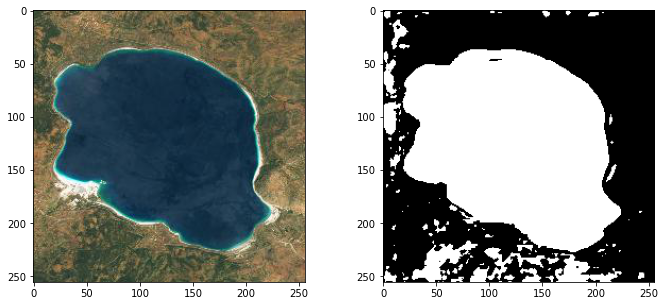

In [11]:
image_path = 's2cloudless_imagery/cropped/turkey_salda_s2cloudless_2018.jpg'
#image_path = 's2cloudless_imagery/cropped/austria_lago_del_careser_s2cloudless_2017.jpg'
#image_path = 'nwpu_images/data/lake_006.jpg'

with rasterio.open(image_path) as dataset:
    bands = dataset.read()
    raw_image = np.ma.transpose(bands, [1, 2, 0])
    original_image = tf.Variable(raw_image)
    resized_image = tf.keras.preprocessing.image.smart_resize(original_image, image_size)
    y_pred = unet_residual.predict(np.expand_dims(resized_image, axis=0))
    display_prediction_result(raw_image, y_pred)